In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gpytorch

# ------------------ Load and Preprocess Data ------------------
data_np = np.load('spatial_temporal_data.npy')
data = data_np[50:60, 100:110, :100]          # (10, 10, 100)
data_mean = data.mean()
data_std = data.std()
data = (data - data_mean) / data_std          # normalize

H, W, T = data.shape
x_grid, y_grid = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
locations = np.stack([x_grid.ravel(), y_grid.ravel()], axis=-1)

# Select 15 random spatial locations
rng = np.random.default_rng(seed=42)
train_indices = rng.choice(locations.shape[0], size=15, replace=False)
train_locs = locations[train_indices]
print("Trained spatial locations (x, y):", [tuple(loc) for loc in train_locs])

train_x_space = torch.tensor(train_locs, dtype=torch.float32)          # (15, 2)
train_x_time = torch.arange(T, dtype=torch.float32).unsqueeze(1)      # (100, 1)

train_inputs = []
train_outputs = []

for i, loc in enumerate(train_locs):
    x_idx, y_idx = loc
    ts = data[x_idx, y_idx]  # (100,)
    loc_tensor = train_x_space[i].repeat(T, 1)  # (100, 2)
    train_inputs.append(torch.cat([loc_tensor, train_x_time], dim=1))  # (100, 3)
    train_outputs.append(torch.tensor(ts, dtype=torch.float32))        # (100,)

train_x = torch.cat(train_inputs, dim=0)   # (15*100, 3)
train_y = torch.cat(train_outputs, dim=0)  # (15*100,)

# Normalize inputs (helps DKL training)
train_x_norm = train_x.clone()
train_x_norm[:, 0] /= (H - 1)
train_x_norm[:, 1] /= (W - 1)
train_x_norm[:, 2] /= (T - 1)

# ------------------ 4-Layer Residual Spatial Feature Extractor ------------------
class SpatialFeatureExtractor(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=32, out_dim=16):  # out_dim=16 (was 8)
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, out_dim)

    def forward(self, x_space):
        # x_space: (N, 2)
        h = F.relu(self.fc1(x_space))          # layer 1

        # Residual block 1
        h = h + F.relu(self.fc2(h))            # layer 2 + skip

        # Residual block 2
        h = h + F.relu(self.fc3(h))            # layer 3 + skip

        # Extra non-residual layer
        h = F.relu(self.fc4(h))                # layer 4

        z = self.out(h)                        # output features (N, out_dim)
        return z

# ------------------ GP Model with DKL in Space + Spectral Mixture in Time ------------------
class SpatioTemporalDKLModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Spatial DKL
        self.feature_extractor = SpatialFeatureExtractor(
            in_dim=2, hidden_dim=32, out_dim=16
        )
        self.covar_module_space = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

        # Temporal Spectral Mixture kernel (time only)
        self.covar_module_time = gpytorch.kernels.SpectralMixtureKernel(
            num_mixtures=4
        )
        self.covar_module_time.initialize_from_data(
            train_x[:, 2:3],  # time column
            train_y
        )

    def forward(self, x):
        """
        x: (N, 3) normalized = (x, y, t)
        """
        mean_x = self.mean_module(x)

        x_space = x[..., :2]    # (N, 2)
        x_time  = x[..., 2:3]   # (N, 1)

        # Deep spatial features
        z = self.feature_extractor(x_space)          # (N, d)
        K_space = self.covar_module_space(z)         # (N, N)

        # Temporal kernel
        K_time  = self.covar_module_time(x_time)     # (N, N)

        covar_x = K_space * K_time
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# ------------------ Train GP ------------------
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = SpatioTemporalDKLModel(train_x_norm, train_y, likelihood)

model.train()
likelihood.train()

# Smaller LR + weight decay for the deeper MLP
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.05,            # was 0.1
    weight_decay=1e-4   # new
)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

num_iters = 100
for i in range(num_iters):
    optimizer.zero_grad()
    output = model(train_x_norm)
    loss = -mll(output, train_y)
    loss.backward()
    # if i % 10 == 0:
    #     print(f"Iter {i:3d} - Loss: {loss.item():.3f}")
    optimizer.step()

# ------------------ Predict on Full Grid ------------------
test_inputs = []
for i in range(H):
    for j in range(W):
        spatial = torch.tensor([i, j], dtype=torch.float32).repeat(T, 1)  # (T, 2)
        temporal = train_x_time                                           # (T, 1)
        combined = torch.cat([spatial, temporal], dim=1)                  # (T, 3)
        test_inputs.append(combined)

test_x = torch.cat(test_inputs, dim=0)  # (H*W*T, 3)

# Normalize test_x the same way
test_x_norm = test_x.clone()
test_x_norm[:, 0] /= (H - 1)
test_x_norm[:, 1] /= (W - 1)
test_x_norm[:, 2] /= (T - 1)

model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_dist = likelihood(model(test_x_norm))
    pred_mean = pred_dist.mean.reshape(H, W, T)


Trained spatial locations (x, y): [(0, 7), (0, 8), (5, 7), (7, 5), (1, 8), (7, 1), (9, 1), (7, 2), (3, 9), (7, 8), (3, 8), (5, 0), (6, 7), (6, 4), (9, 4)]


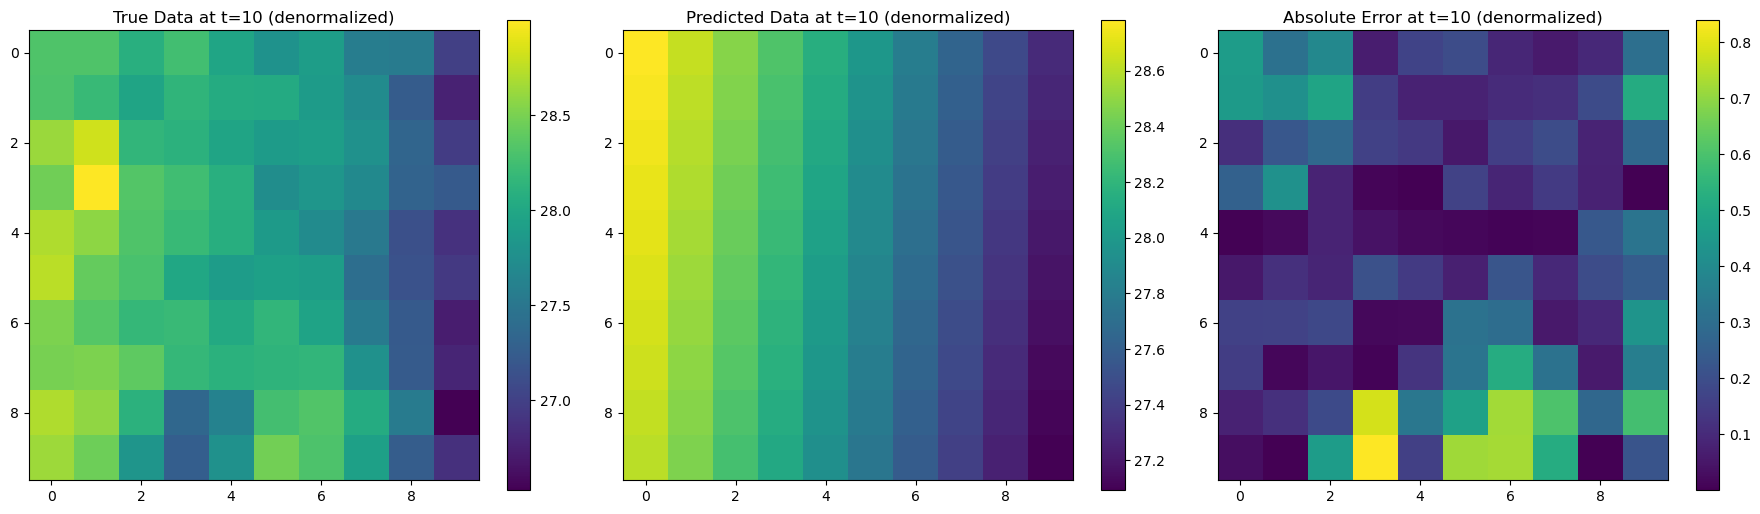

In [2]:
# ------------------ Plot True, Predicted, and RMSE Heatmaps ------------------
t0 = 10  # Change this to visualize different time steps

# Denormalize the true and predicted data
true_data_t0 = data[:, :, t0] * data_std + data_mean
predicted_data_t0 = pred_mean[:, :, t0] * data_std + data_mean

# Compute RMSE at each location for this time step
rmse_t0 = torch.abs(pred_mean[:, :, t0] - torch.tensor(data[:, :, t0])) * data_std
rmse_t0 = rmse_t0.detach().cpu().numpy()

# Convert predicted if necessary
if torch.is_tensor(predicted_data_t0):
    predicted_data_t0 = predicted_data_t0.detach().cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# True data
im0 = axs[0].imshow(true_data_t0, cmap='viridis')
axs[0].set_title(f'True Data at t={t0} (denormalized)')
plt.colorbar(im0, ax=axs[0])

# Predicted data
im1 = axs[1].imshow(predicted_data_t0, cmap='viridis')
axs[1].set_title(f'Predicted Data at t={t0} (denormalized)')
plt.colorbar(im1, ax=axs[1])

# Absolute error
im2 = axs[2].imshow(rmse_t0, cmap='viridis')
axs[2].set_title(f'Absolute Error at t={t0} (denormalized)')
plt.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()


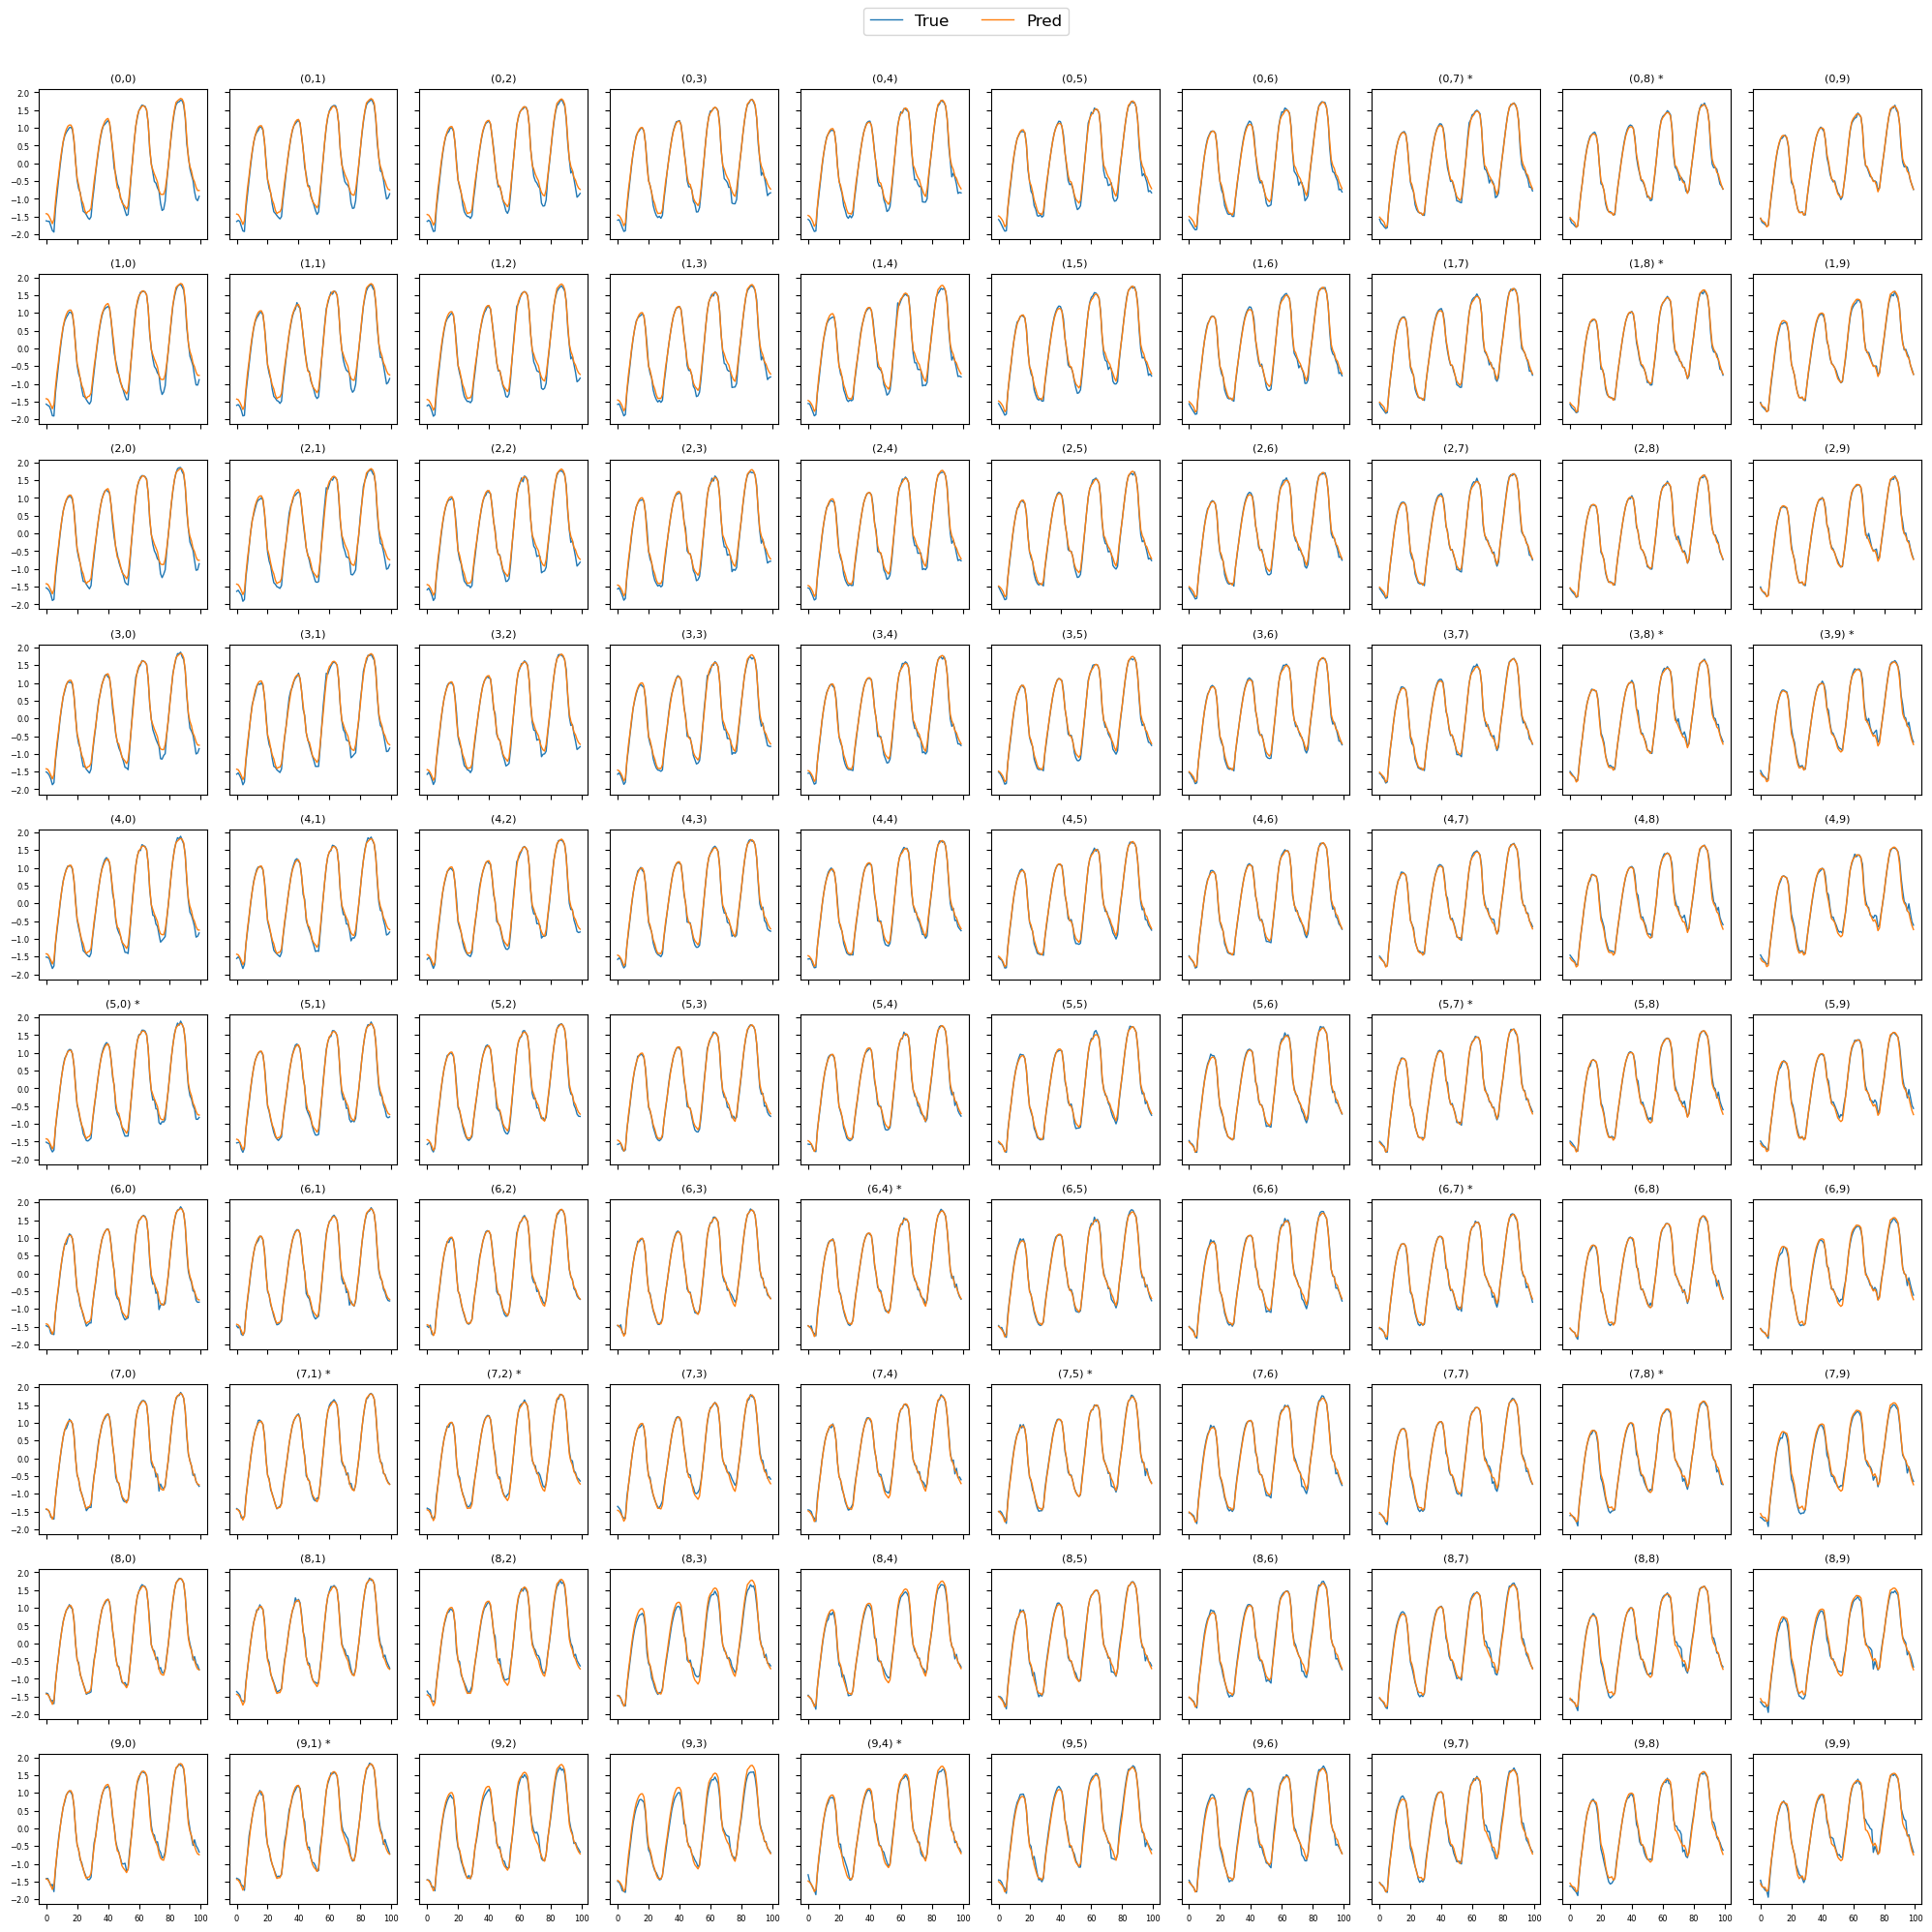

In [3]:
# Time series comparison for all locations
train_locs_set = set(tuple(loc) for loc in train_locs)
fig, axs = plt.subplots(H, W, figsize=(20, 20), sharex=True, sharey=True)
for i in range(H):
    for j in range(W):
        axs[i, j].plot(data[i, j, :], label='True', linewidth=1)
        axs[i, j].plot(pred_mean[i, j, :].detach().cpu().numpy(), label='Pred', linewidth=1)
        title = f'({i},{j})'
        if (i, j) in train_locs_set:
            title += ' *'
        axs[i, j].set_title(title, fontsize=8)
        axs[i, j].tick_params(labelsize=6)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

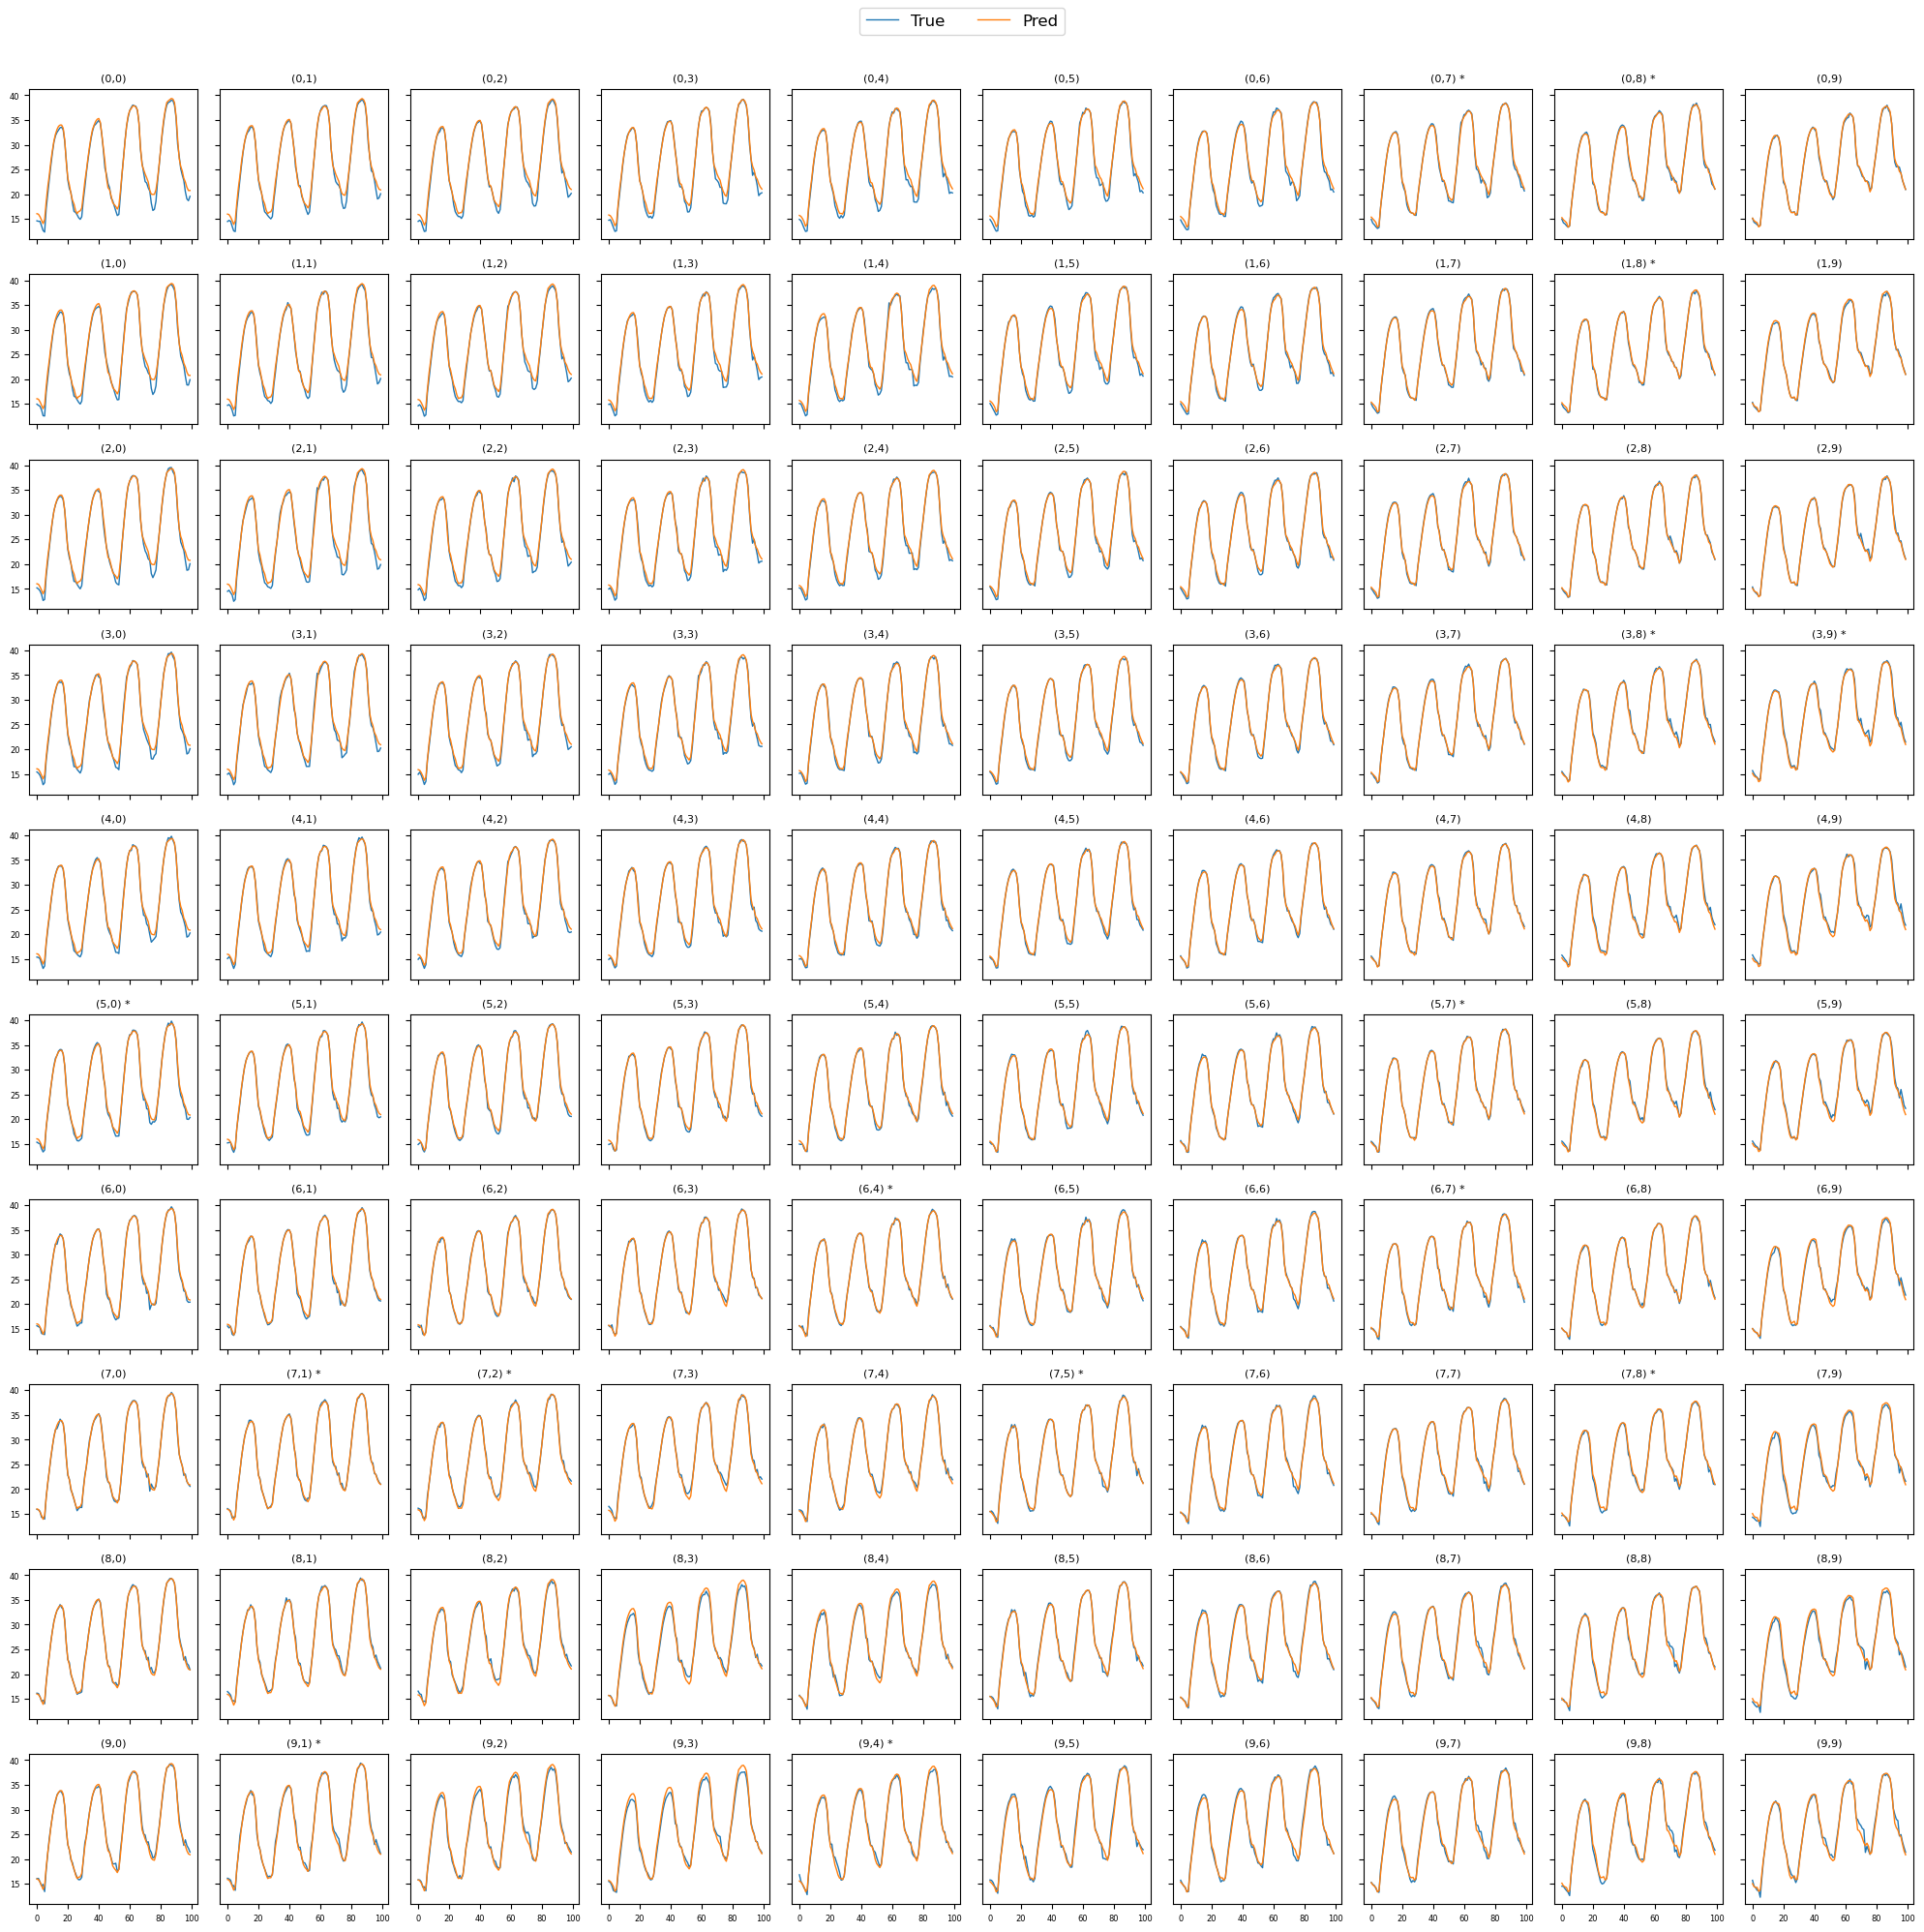

In [4]:
# Time series comparison for all locations (denormalized)
train_locs_set = set(tuple(loc) for loc in train_locs)
fig, axs = plt.subplots(H, W, figsize=(20, 20), sharex=True, sharey=True)

for i in range(H):
    for j in range(W):
        true_ts = data[i, j, :] * data_std + data_mean
        pred_ts = pred_mean[i, j, :] * data_std + data_mean

        axs[i, j].plot(true_ts, label='True', linewidth=1)
        axs[i, j].plot(pred_ts.detach().cpu().numpy(), label='Pred', linewidth=1)

        title = f'({i},{j})'
        if (i, j) in train_locs_set:
            title += ' *'
        axs[i, j].set_title(title, fontsize=8)
        axs[i, j].tick_params(labelsize=6)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


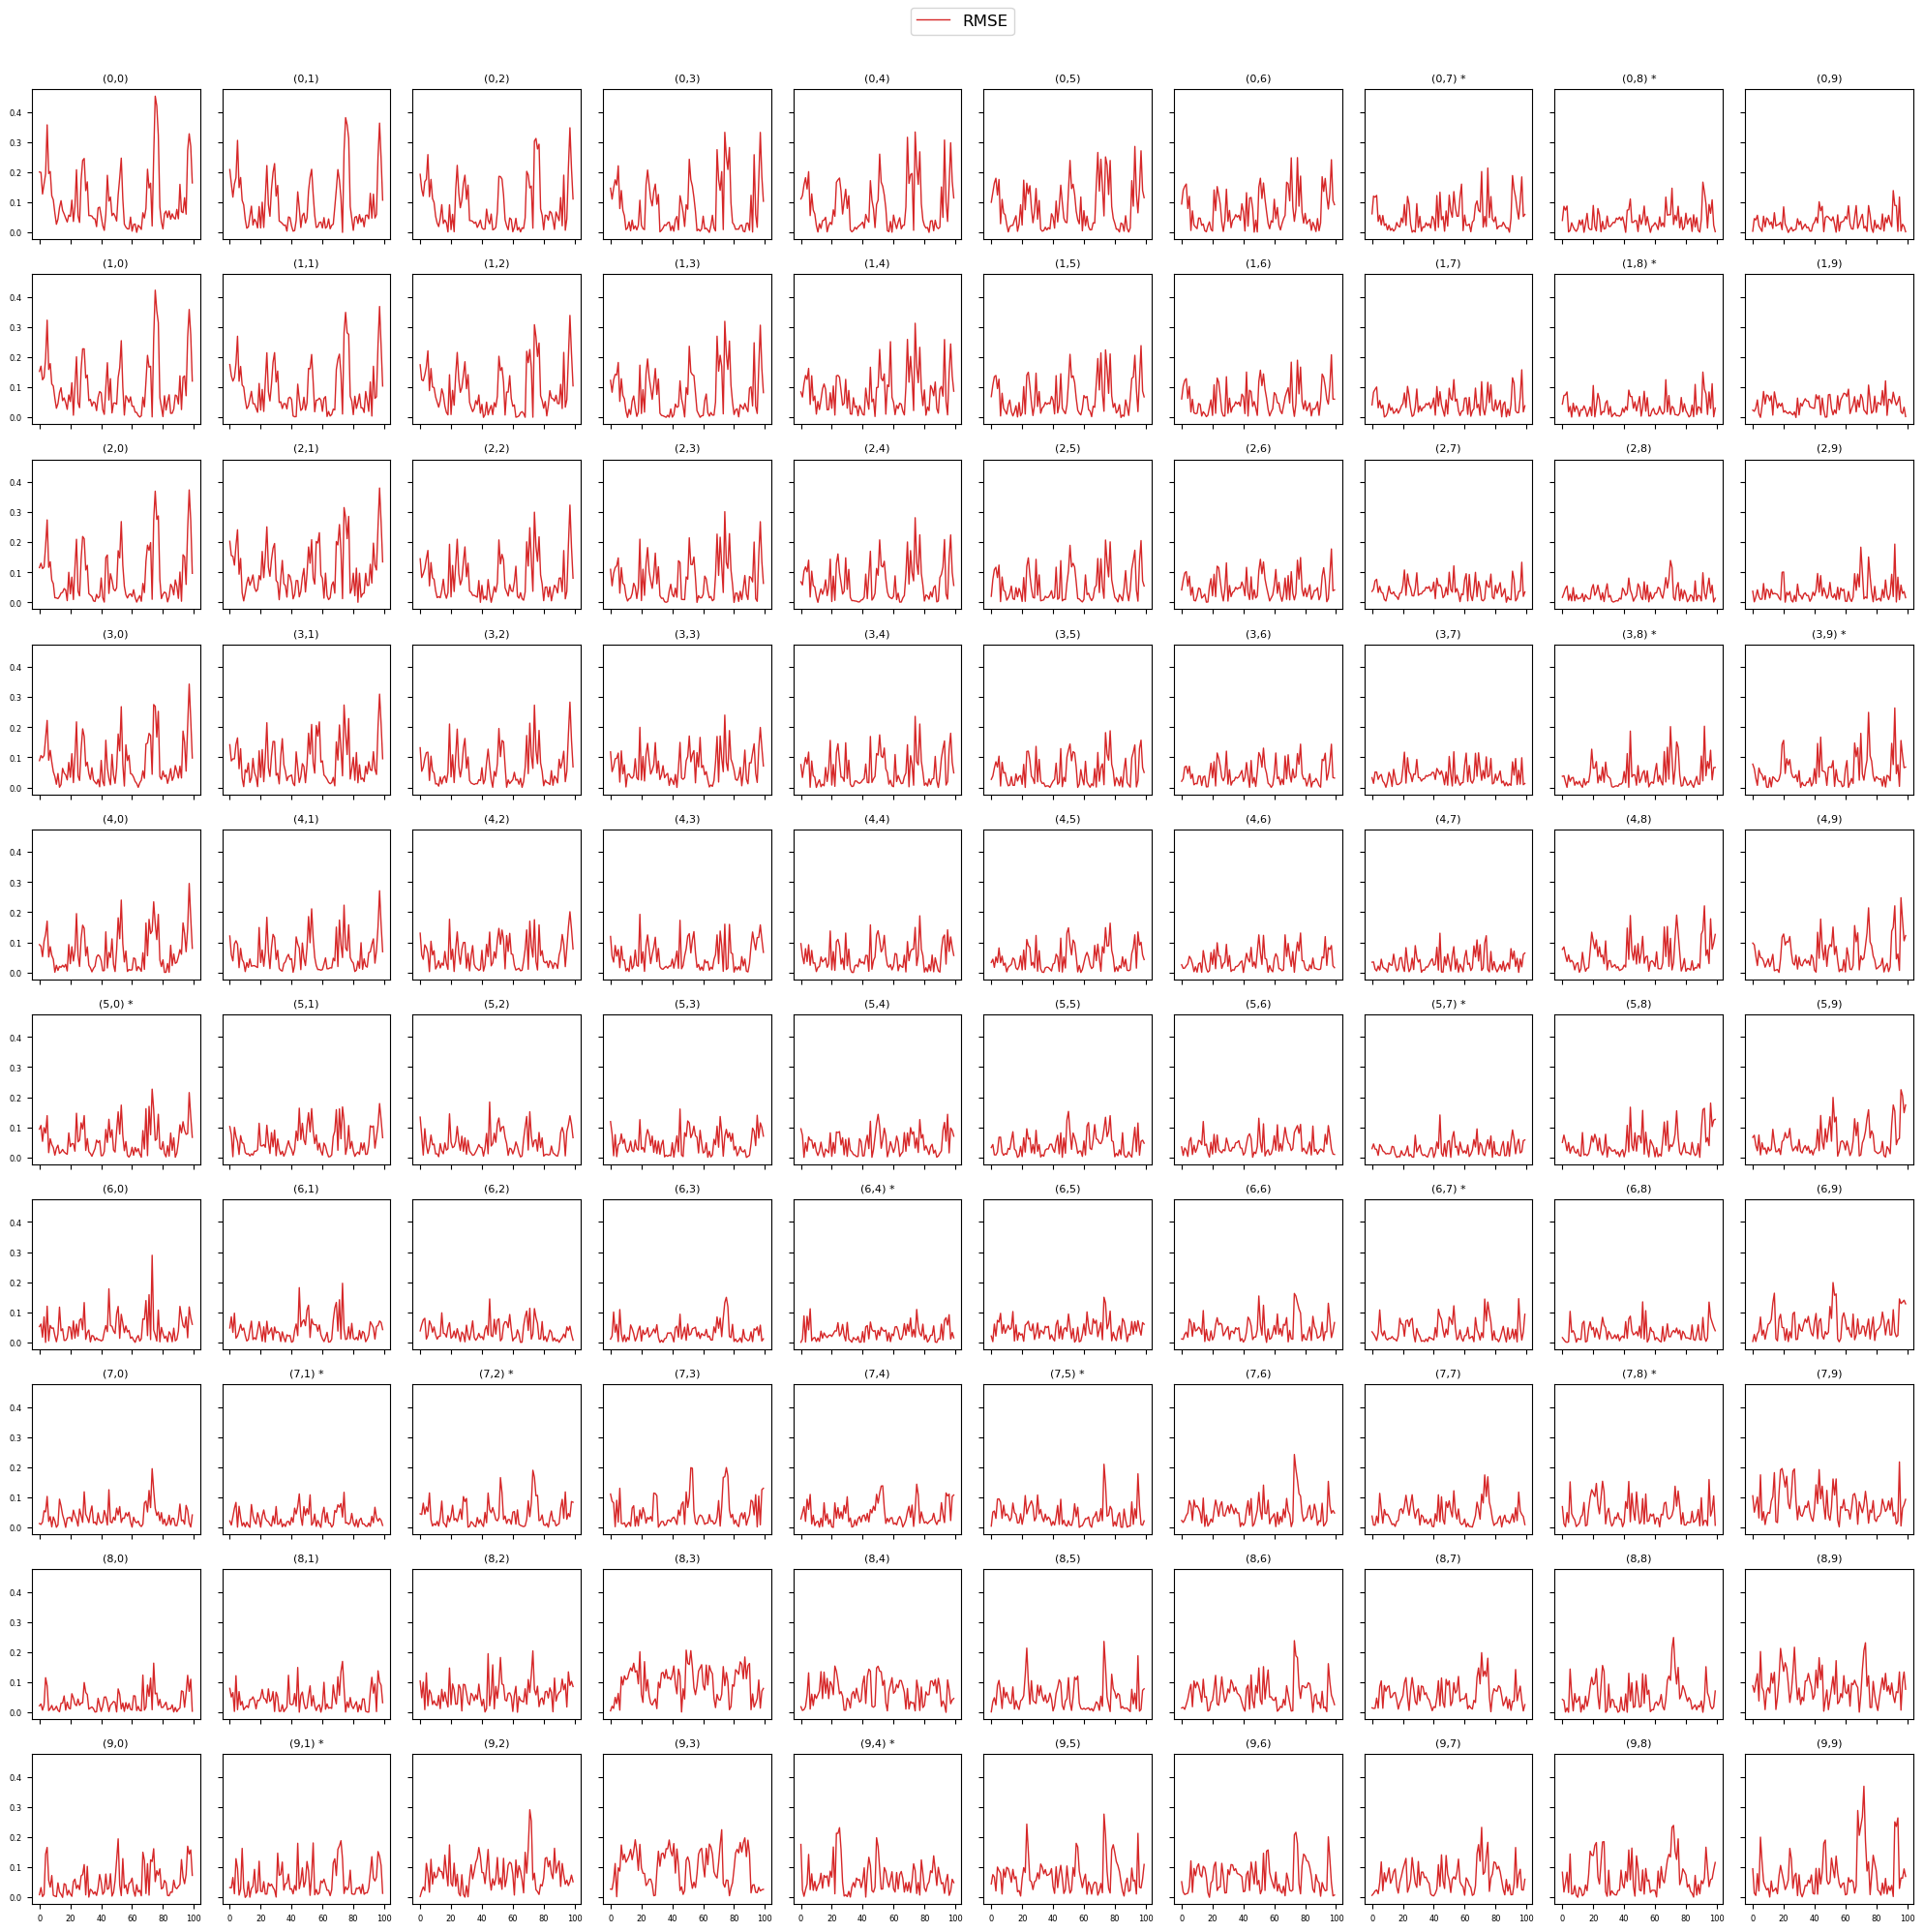

In [5]:
# Time series RMSE comparison for all locations
train_locs_set = set(tuple(loc) for loc in train_locs)
fig, axs = plt.subplots(H, W, figsize=(20, 20), sharex=True, sharey=True)
for i in range(H):
    for j in range(W):
        rmse_ts = torch.sqrt((pred_mean[i, j, :] - torch.tensor(data[i, j, :])) ** 2).detach().cpu().numpy()
        axs[i, j].plot(rmse_ts, label='RMSE', linewidth=1, color='tab:red')
        title = f'({i},{j})'
        if (i, j) in train_locs_set:
            title += ' *'
        axs[i, j].set_title(title, fontsize=8)
        axs[i, j].tick_params(labelsize=6)

fig.legend(['RMSE'], loc='upper center', ncol=1, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


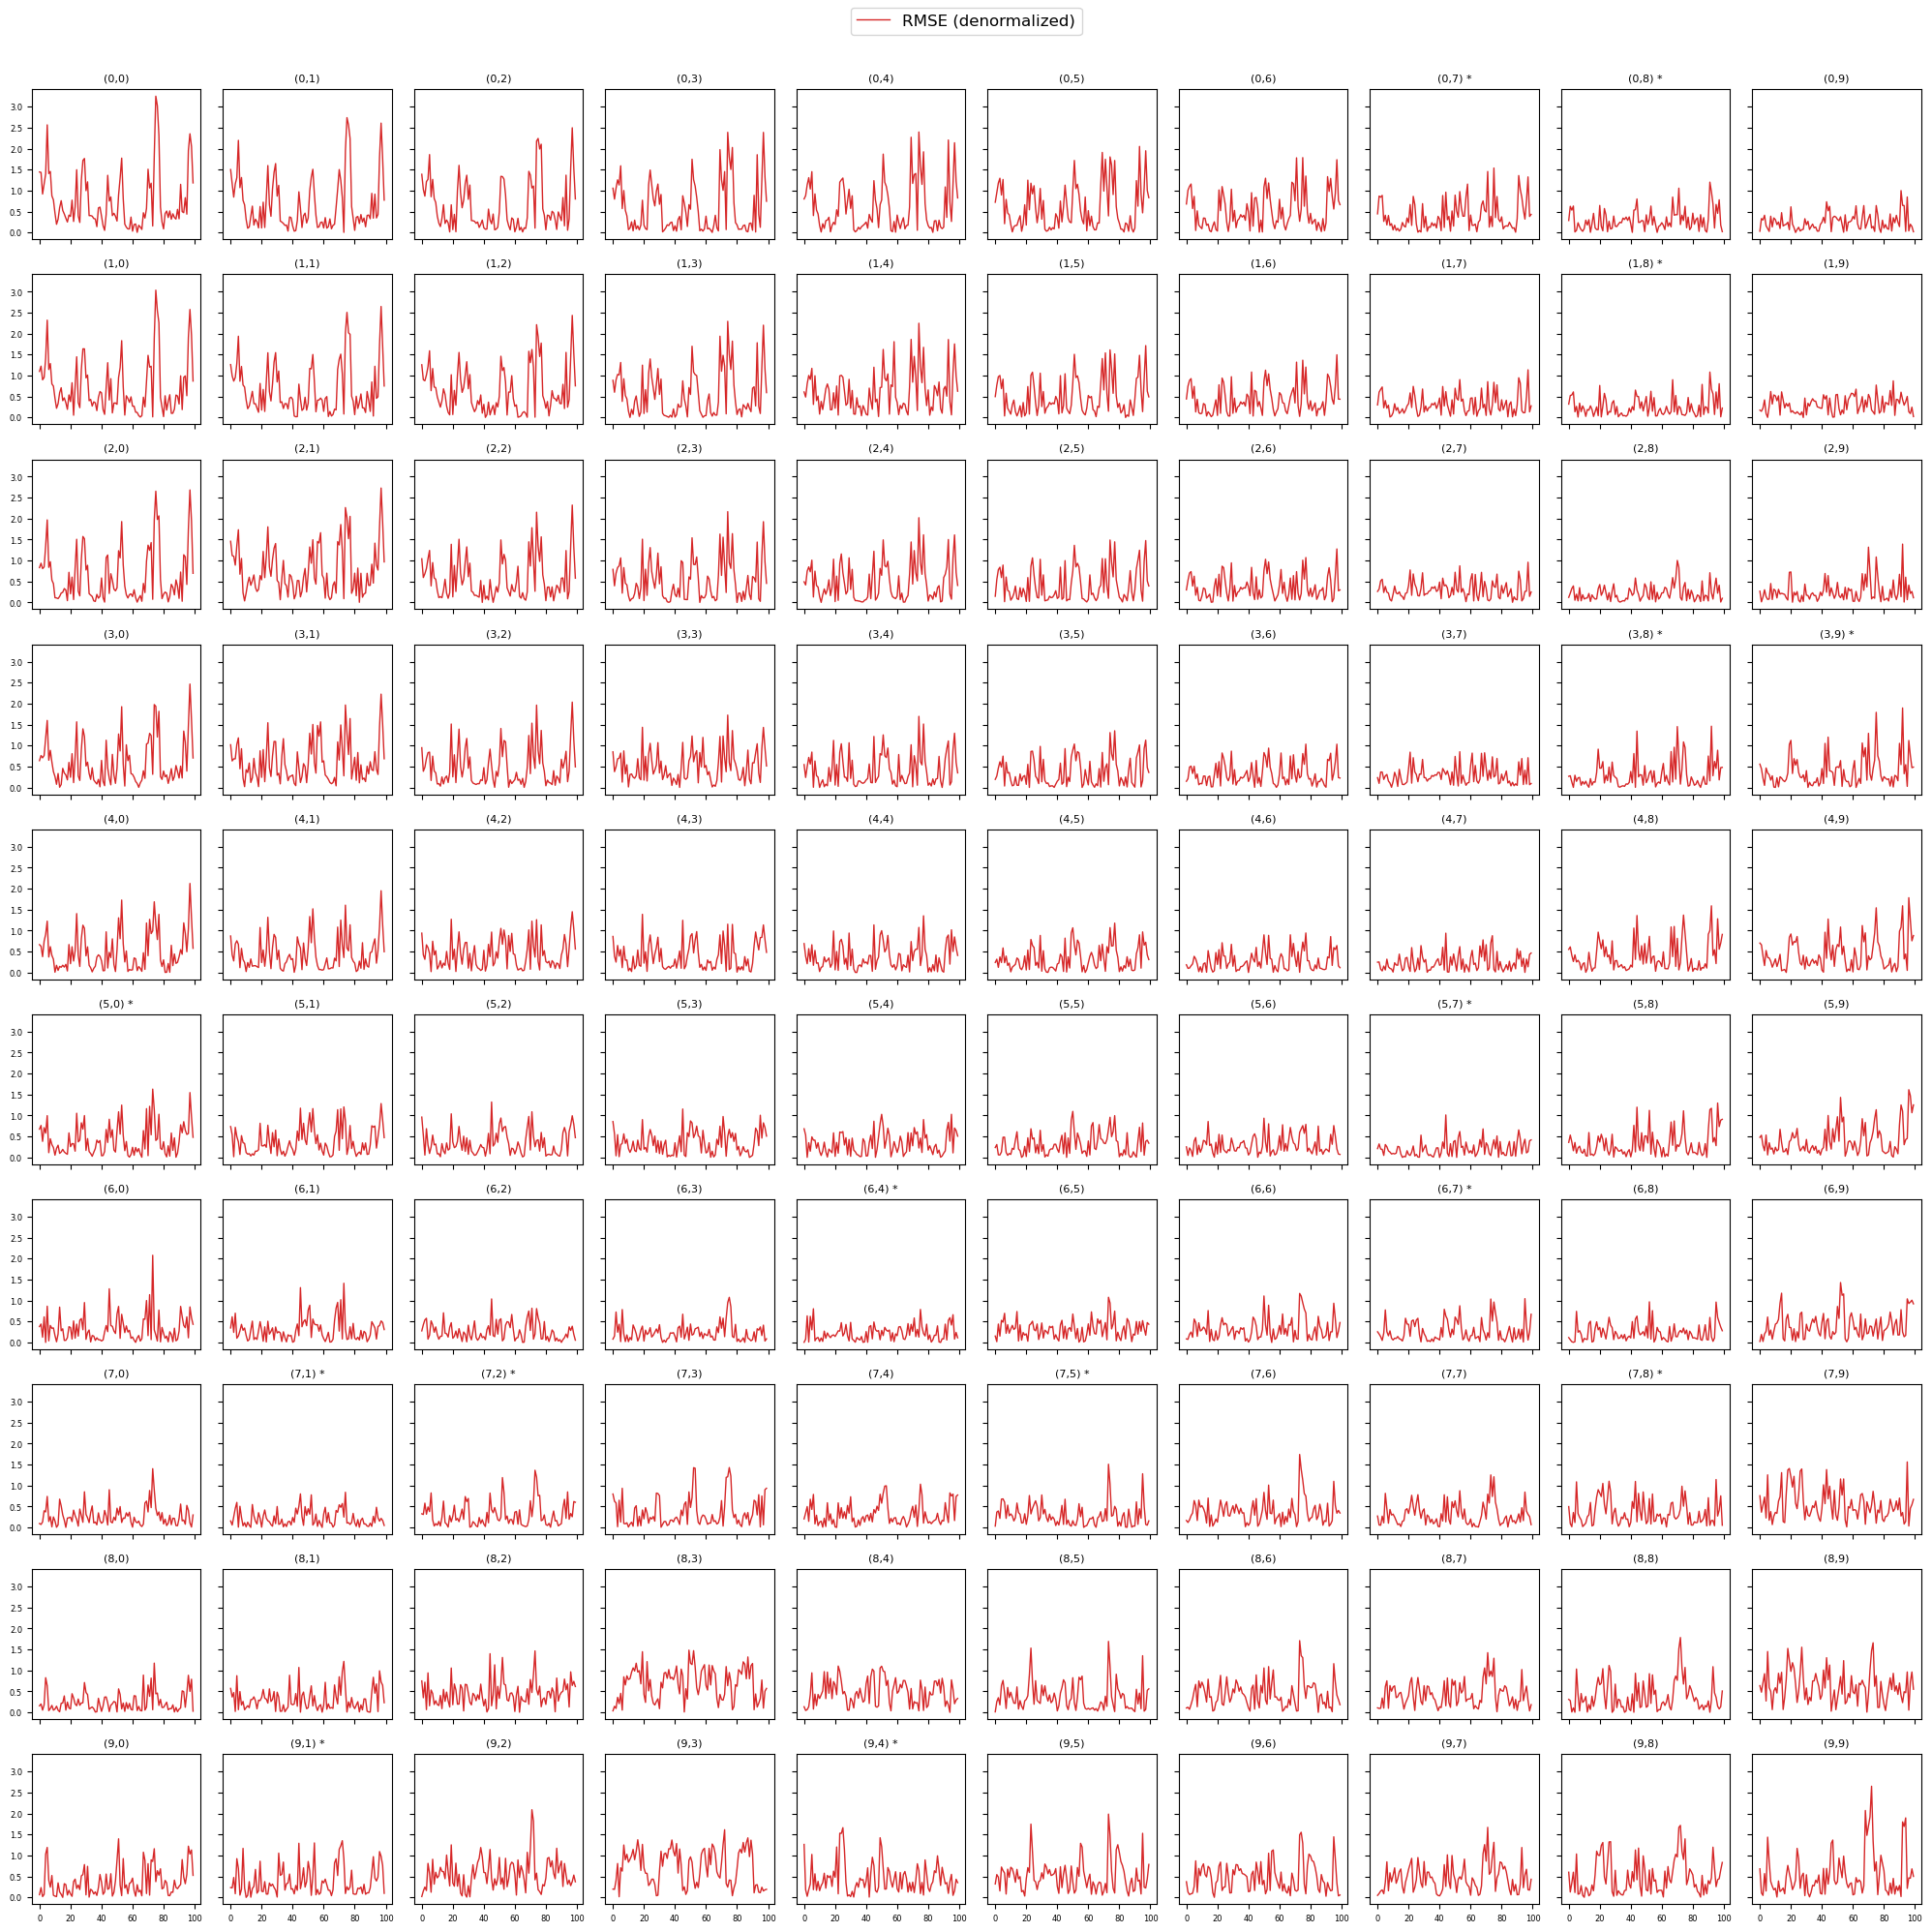

In [6]:
train_locs_set = set(tuple(loc) for loc in train_locs)
fig, axs = plt.subplots(H, W, figsize=(20, 20), sharex=True, sharey=True)

for i in range(H):
    for j in range(W):
        # Compute squared error in normalized space
        sq_err = (pred_mean[i, j, :] - torch.tensor(data[i, j, :])) ** 2
        # Convert to RMSE in original scale
        rmse_ts = torch.sqrt(sq_err) * data_std
        rmse_ts = rmse_ts.detach().cpu().numpy()

        axs[i, j].plot(rmse_ts, label='RMSE', linewidth=1, color='tab:red')
        title = f'({i},{j})'
        if (i, j) in train_locs_set:
            title += ' *'
        axs[i, j].set_title(title, fontsize=8)
        axs[i, j].tick_params(labelsize=6)

fig.legend(['RMSE (denormalized)'], loc='upper center', ncol=1, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


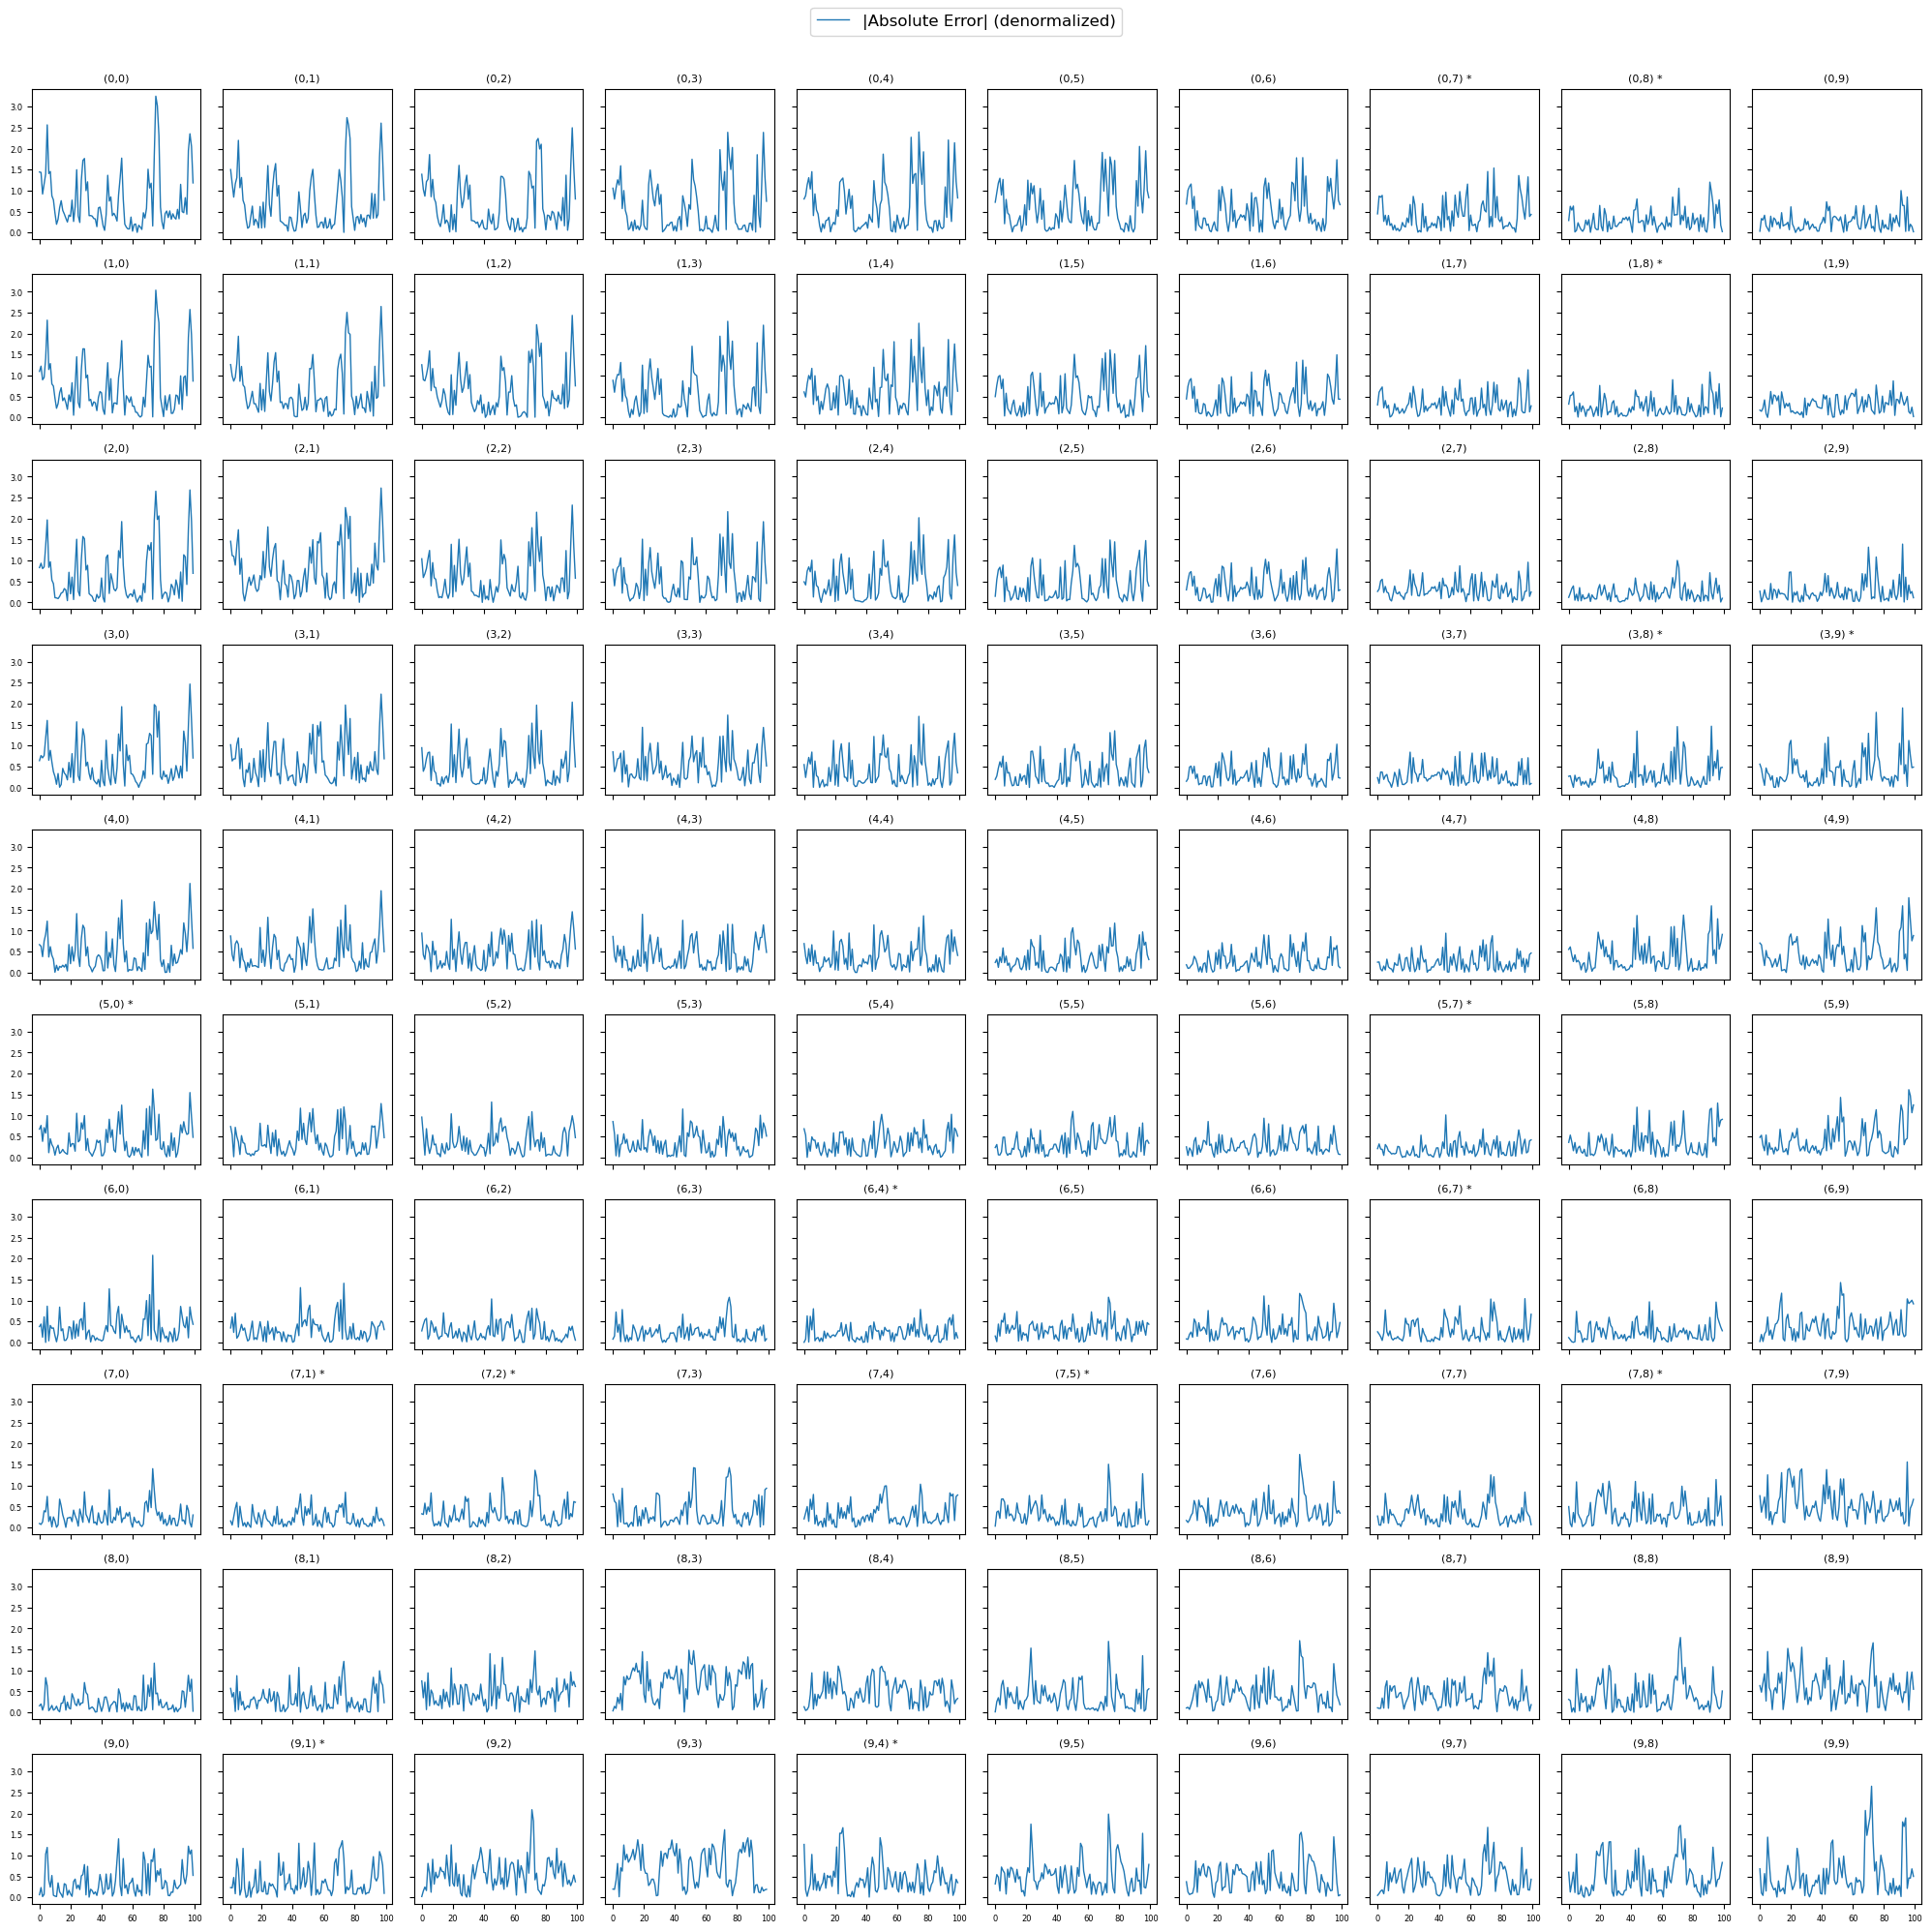

In [7]:
train_locs_set = set(tuple(loc) for loc in train_locs)
fig, axs = plt.subplots(H, W, figsize=(20, 20), sharex=True, sharey=True)

for i in range(H):
    for j in range(W):
        # Compute absolute error in normalized space, then scale to original units
        abs_err = torch.abs(pred_mean[i, j, :] - torch.tensor(data[i, j, :])) * data_std
        abs_err = abs_err.detach().cpu().numpy()

        axs[i, j].plot(abs_err, label='|Error|', linewidth=1, color='tab:blue')
        title = f'({i},{j})'
        if (i, j) in train_locs_set:
            title += ' *'
        axs[i, j].set_title(title, fontsize=8)
        axs[i, j].tick_params(labelsize=6)

fig.legend(['|Absolute Error| (denormalized)'], loc='upper center', ncol=1, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
